<a href="https://colab.research.google.com/github/agkabir/AnomalyDetection/blob/main/Tmie_Series_Anomaly_Detection_LSTMVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series Anomaly Detection
Import of necessary libraries.

In [ ]:

from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

from torch import nn, optim
import math
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import copy
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

cuda = torch.cuda.is_available()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, confusion_matrix, roc_auc_score

In [ ]:
# defining hyperperameter
hidden_size = 64
num_layers = 1
latent_size = 20
batch_size = 32
learning_rate = 0.005
n_epochs = 50
dropout_rate = 0.2
RANDOM_SEED = 42
print_every=10
clip = True # options: True, False
max_grad_norm=5
num_samples = 20

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# mounting of google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
normal_df = pd.read_csv('/content/drive/My Drive/adml/normal_df.csv')
anomaly_df = pd.read_csv('/content/drive/My Drive/adml/anomaly_df.csv')


In [ ]:
#normal_df = pd.read_csv('./ECG5000/normal_df.csv', delimiter=',')
#anomaly_df = pd.read_csv('./ECG5000/anomaly_df.csv',delimiter=',')
#normal_df.head()
X =normal_df.values
X= np.expand_dims(X, -1)

In [ ]:
# split of the dataset for train, test and validation
X_train, X_val = train_test_split(X,test_size=0.15,random_state=RANDOM_SEED)
X_val, X_test = train_test_split(X_val,test_size=0.33, random_state=RANDOM_SEED)
anomaly = np.expand_dims(anomaly_df.values, -1)

# creating dataset
train_dataset = TensorDataset(torch.from_numpy(X_train).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float())
anomaly_dataset = TensorDataset(torch.from_numpy(anomaly).float())


In [ ]:
# generating data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=cuda)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, pin_memory=cuda)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, pin_memory=cuda)

# Building Model

In [ ]:
class LSTMVAE(nn.Module):
    def __init__(self,number_of_features, hidden_size, dropout_rate, latent_size, sequence_length,batch_size, num_layers, num_samples, bidirectional=False):

        super().__init__()
        
        self.sequence_length = sequence_length
        
        self.latent_size = latent_size
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.number_of_features = number_of_features
        self.batch_size = batch_size
        self.num_samples = num_samples
            
        self.dec_layers = (2 if bidirectional else 1) * num_layers    
        self.encoder_rnn = nn.LSTM(number_of_features, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)
        self.hidden_factor = (2 if bidirectional else 1) * num_layers
        self.hidden2mean = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.hidden2logv = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.latent2hidden = nn.Linear(latent_size, hidden_size * self.hidden_factor)
        self.decoder_rnn = nn.LSTM(hidden_size * self.hidden_factor, hidden_size * (2 if bidirectional else 1),num_layers=self.dec_layers,batch_first=True)
        self.hidden2output = nn.Linear(hidden_size * (2 if bidirectional else 1), self.number_of_features)
        
    def reparameterize(self,hidden):
        mu = self.hidden2mean(hidden)
        log_var = self.hidden2logv(hidden)
        std = torch.exp(0.5 * log_var)
        batch_size = mu.size(0)

        eps = torch.randn(batch_size, self.num_samples, self.latent_size)
        z = mu.unsqueeze(1) + eps * std.unsqueeze(1) 
        z = torch.mean(z, dim=1)
        return z, mu, log_var
  
    def forward(self, x):
        outputs = {}
        # ENCODER
        x, (h_end, c_end) = self.encoder_rnn(x)
        #print(h_end.shape)
        if self.bidirectional or self.num_layers > 1:
            # flatten hidden state
            hidden = h_end.view(-1, self.hidden_size*self.hidden_factor)
        else:
            hidden = h_end.squeeze()
            
        # REPARAMETERIZATION
        z, mu, log_var = self.reparameterize(hidden)
        # DECODER
        x = self.latent2hidden(z)
        x = x.unsqueeze(1).repeat(1, self.sequence_length, 1)
        x, (hidden_state, cell_state) = self.decoder_rnn(x)
        x = x.reshape((-1, self.sequence_length, self.hidden_size * (2 if self.bidirectional else 1)))
      
        # decoder forward pass
        
        x_hat = self.hidden2output(x)
        
        # RE ENCODER
        x_hat_bar, (h_end_bar, c_end_bar) = self.encoder_rnn(x_hat)
        #print(h_end.shape)
        if self.bidirectional or self.num_layers > 1:
            # flatten hidden state
            hidden_bar = h_end_bar.view(-1, self.hidden_size*self.hidden_factor)
        else:
            hidden_bar = h_end_bar.squeeze()
        # REPARAMETERIZATION
        z_bar,mu_bar, log_var_bar = self.reparameterize(hidden_bar)
        
        ### collect all output
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        outputs["z_bar"] = z_bar
        outputs["mu_bar"] = mu_bar
        outputs["log_var"] = log_var_bar
        
        return outputs
        

In [ ]:
sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

In [ ]:
net = LSTMVAE(number_of_features, hidden_size, dropout_rate, latent_size, sequence_length,batch_size, num_layers, num_samples, bidirectional=True)

In [ ]:
print(net)

LSTMVAE(
  (encoder_rnn): LSTM(1, 64, batch_first=True, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=20, bias=True)
  (hidden2logv): Linear(in_features=128, out_features=20, bias=True)
  (latent2hidden): Linear(in_features=20, out_features=128, bias=True)
  (decoder_rnn): LSTM(128, 128, num_layers=2, batch_first=True)
  (hidden2output): Linear(in_features=128, out_features=1, bias=True)
)


# Defing Loss functon

In [ ]:
from torch import optim
#criterion = nn.SmoothL1Loss(size_average=False)
criterion = nn.MSELoss(size_average=False)
def ELBO_loss(y, t, z,mu, log_var,z_bar,mu_bar,log_var_bar):
    recon_loss = criterion(y, t)
    ## recon latent
    latent_loss = criterion(z, z_bar)
    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var))
    # latent kl
    latent_kl = -0.5 * torch.sum(1 + log_var_bar - mu_bar**2 - torch.exp(log_var_bar))
   
    # Combining the two terms in the evidence lower bound objective (ELBO) 
    ELBO = recon_loss + kl
    total = recon_loss + kl + latent_loss + latent_kl
    
    return total, ELBO,kl


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.0005)
loss_function = ELBO_loss

In [ ]:
from torch.autograd import Variable

X= next(iter(train_loader))
x = X[0]
outputs = net(x.float())

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
mu_bar, log_var_bar = outputs["mu"], outputs["log_var"]
z, z_bar = outputs["z"], outputs["z_bar"]

loss, elbo,kl = loss_function(x_hat, x, z, mu, log_var,z_bar,mu_bar,log_var_bar)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(kl)
print(elbo)

torch.Size([32, 140, 1])
torch.Size([32, 140, 1])
torch.Size([32, 20])
tensor(0.0028, grad_fn=<MulBackward0>)
tensor(4436.9624, grad_fn=<AddBackward0>)


# Model Training

In [ ]:
import os
def train_model(model,train_dataset,val_dataset,num_epochs):
    history_elbo = dict(train_elbo=[], val_elbo=[])
    history_kl = dict(train_kl=[], val_kl=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    device = torch.device("cuda:0" if cuda else "cpu")
    print("Using device:", device)
    
    for epoch in range(num_epochs):
        model.train()
        # Go through  in the training dataset 
        train_elbo_losses, train_kl_losses = [], []
        for t, X in enumerate(train_dataset):
            # Index first element of array to return tensor
            X = X[0]
            # This is an alternative way of putting
            # a tensor on the GPU
            x = X
          
            outputs = model(x)
            x_hat = outputs['x_hat']
            mu, log_var = outputs['mu'], outputs['log_var']
            mu_bar, log_var_bar = outputs["mu_bar"], outputs["log_var"]
            z, z_bar = outputs["z"], outputs["z_bar"]

            loss, elbo,kl = loss_function(x_hat, x, z, mu, log_var,z_bar,mu_bar,log_var_bar)
          
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
            train_elbo_losses.append(elbo.item())
            train_kl_losses.append(kl.item())

      # Evaluate, do not propagate gradients
        with torch.no_grad():
            model.eval()
        valid_elbo_losses, valid_kl_losses = [], []   
        for t, X in enumerate(val_dataset):
            X = X[0]
            x = X
            outputs = model(x)
            x_hat = outputs['x_hat']
            mu, log_var = outputs['mu'], outputs['log_var']
            mu_bar, log_var_bar = outputs["mu_bar"], outputs["log_var"]
            z, z_bar = outputs["z"], outputs["z_bar"]

            loss, elbo,kl = loss_function(x_hat, x, z, mu, log_var,z_bar,mu_bar,log_var_bar)
          
            valid_elbo_losses.append(elbo.item())
            valid_kl_losses.append(kl.item())
      
        train_elbo_loss = np.mean(train_elbo_losses)
        train_kl_loss = np.mean(train_kl_losses)
        valid_elbo_loss = np.mean(valid_elbo_losses)
        valid_kl_loss = np.mean(valid_kl_losses)
        if valid_elbo_loss < best_loss:
            best_loss = valid_elbo_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch}: train elbo loss {train_elbo_loss} train kl loss {train_kl_loss} val elbo loss {valid_elbo_loss} valid kl loss {valid_kl_loss}') 

      # collecting losses
        history_elbo['train_elbo'].append(train_elbo_loss)
        history_kl['train_kl'].append(train_kl_loss)
        history_elbo['val_elbo'].append(valid_elbo_loss)
        history_kl['val_kl'].append(valid_kl_loss)
    model.load_state_dict(best_model_wts)
    return model.eval(),history_elbo,history_kl

In [ ]:
model, history_elbo,history_kl = train_model(net,train_loader,val_loader,50)

Using device: cuda:0
Epoch 0: train elbo loss 3538.3309513972354 train kl loss 2.977680143637535 val elbo loss 2679.9861114501955 valid kl loss 4.121983671188355
Epoch 1: train elbo loss 2348.260228866186 train kl loss 13.511079696508554 val elbo loss 1645.1747787475585 valid kl loss 13.663645005226135
Epoch 2: train elbo loss 1657.2115040314504 train kl loss 8.803653350243202 val elbo loss 1423.194760131836 valid kl loss 5.278932404518128
Epoch 3: train elbo loss 1563.9437428009817 train kl loss 4.683606778964018 val elbo loss 1433.479476928711 valid kl loss 3.3376548290252686
Epoch 4: train elbo loss 1561.5587635529348 train kl loss 3.2444531535490966 val elbo loss 1415.1730514526366 valid kl loss 2.452797618508339
Epoch 5: train elbo loss 1553.600341014373 train kl loss 2.5046961032427273 val elbo loss 1405.3913223266602 valid kl loss 1.964235544204712
Epoch 6: train elbo loss 1550.4417521158855 train kl loss 2.023393858701755 val elbo loss 1407.2230728149414 valid kl loss 1.6039244

# Results

In [ ]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

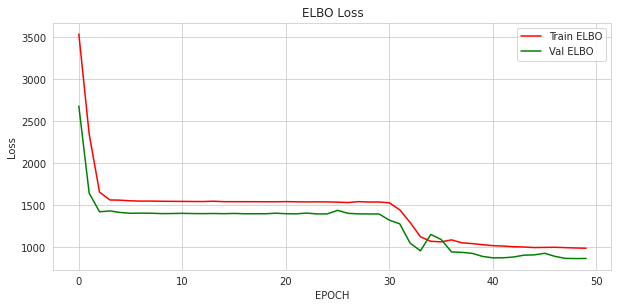

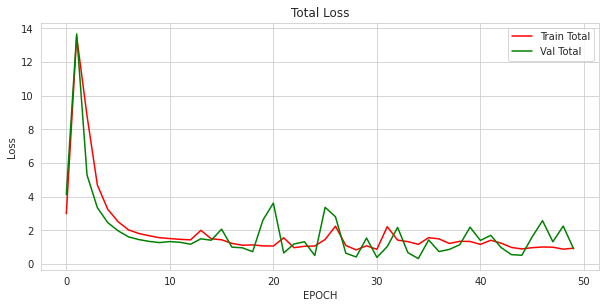

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['val_elbo']))), history_elbo['val_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')
plt.show();

plt.figure(figsize=(10,10))
plt.subplot(212)
plt.plot(list(range(0,len(history_kl['train_kl']))), history_kl['train_kl'], 'r')
plt.plot(list(range(0,len(history_kl['val_kl']))), history_kl['val_kl'],'g')
plt.legend(['Train Total','Val Total'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('Total Loss')

plt.show();

In [ ]:
def predict(model, dataset):
    predictions= []
    with torch.no_grad():
        model = model.eval()
    for t, X in enumerate(dataset):
        X = X[0]
        x = X
        #x = Variable(x, requires_grad = False)
        outputs = model(x)
        x_hat = np.squeeze(outputs['x_hat'].detach().numpy(), axis=2)
        predictions.append(x_hat)
    predictions = np.concatenate(predictions, axis=0)
    return predictions

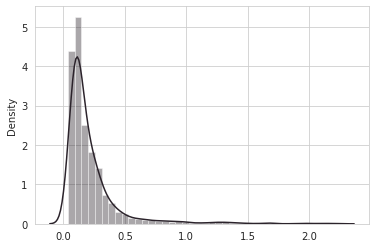

In [ ]:
predict_train = predict(model, train_loader)
train_original = np.squeeze(X_train,axis=2)
train_sq_loss = np.mean(( train_original- predict_train)**2, axis=1)
sns.distplot(train_sq_loss, bins=40, kde=True)
plt.show()

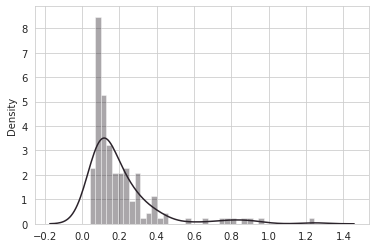

In [ ]:
predict_test = predict(model, test_loader)
test_original = np.squeeze(X_test,axis=2)
test_sq_loss = np.mean(( test_original- predict_test)**2, axis=1)
sns.distplot(test_sq_loss, bins=40, kde=True)
plt.show()

In [ ]:
anomaly = anomaly_df.values
anomaly_dataset = TensorDataset(torch.from_numpy(np.expand_dims(anomaly, -1)).float())
anomaly_loader  = DataLoader(anomaly_dataset, batch_size=batch_size, pin_memory=cuda)
predict_anomaly = predict(model, anomaly_loader)

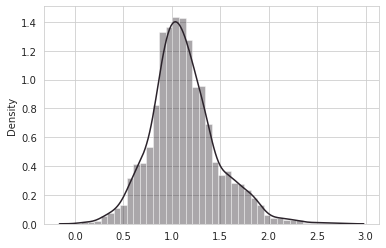

In [ ]:
anomaly_sq_loss = np.mean(( anomaly - predict_anomaly)**2, axis=1)
sns.distplot(anomaly_sq_loss, bins=40, kde=True)
plt.show()

In [ ]:
THRESHOLD = 0.35

In [ ]:
correct = sum(l <= THRESHOLD for l in test_sq_loss)
print(f'Correct normal predictions: {correct}/{len(test_sq_loss)}')

Correct normal predictions: 126/145


In [ ]:
def plot_prediction(data, reconstructed, title, ax):
  ax.plot(data,'r', label='true')
  ax.plot(reconstructed, 'b',label='reconstructed')
  ax.set_title(f'{title} (Total loss: {np.around(np.mean(( data- reconstructed)**2), 2)})')
  ax.legend()

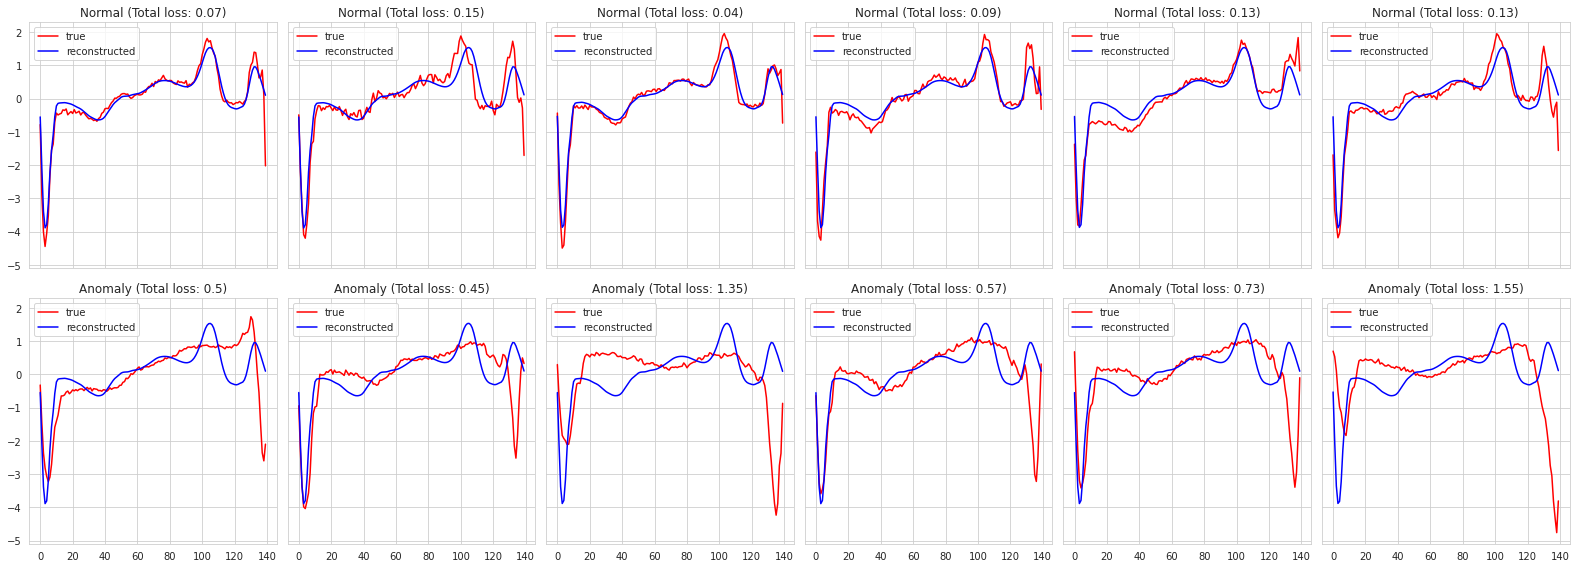

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharey=True,sharex=True,figsize=(22, 8))

for i,data in enumerate(test_original[0:6]):
    plot_prediction(data, predict_test[i], title='Normal', ax=axs[0, i])

for i, data in enumerate(anomaly[0:6]):
    plot_prediction(data, predict_anomaly[i], title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [ ]:
correct = sum(l > THRESHOLD for l in anomaly_sq_loss)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_sq_loss)}')

Correct anomaly predictions: 2065/2081


In [ ]:
label = np.concatenate((np.ones(len(test_sq_loss)),np.zeros(len(test_sq_loss))))
#total_losses = np.concatenate((train_sq_loss,anomaly_sq_loss),axis=0)
total_losses = np.concatenate((test_sq_loss,np.random.choice(anomaly_sq_loss, len(test_sq_loss),replace=False)),axis=0)
error_df = pd.DataFrame({'Reconstruction_error': total_losses,'Label':label})
#error_df = error_df.sample(frac=1)
error_df.head(2)

,Reconstruction_error,Label
0,0.068439,1.0
1,0.149536,1.0


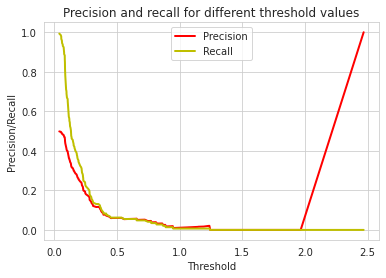

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Label, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:],'r', label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:],'y', label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
threshold_fixed = 0.35

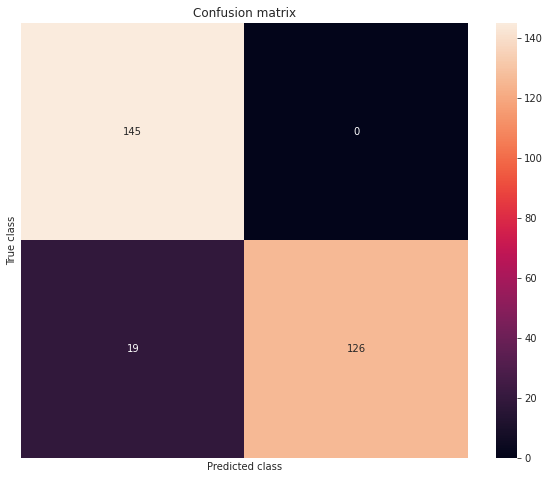

In [ ]:
pred_y = [0 if e > threshold_fixed else 1 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Label, pred_y)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=[], yticklabels=[], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

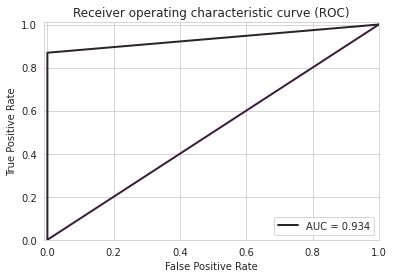

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.Label, pred_y)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=2)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
threshold=0
f1=0
recall=0
accuracy=0
iterations = 10000
while (recall < 0.75 or accuracy < 0.8):
    if iterations == 0:
        break
    print ('**************************')
    print (threshold)
    threshold+=.005
    y_pred = [0 if e > threshold else 1 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.Label, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    precision = 1.*tp/(tp+fp)
    recall = 1.*tp/(tp+fn)
    f1=(2*recall*precision)/(recall+precision)
    print ('TP:'+str(tp))
    print ('FP:'+str(fp))
    print ('TN:'+str(tn))
    print ('FN:'+str(fn))
    accuracy=1.*(tp+tn)/(tp+tn+fp+fn)
    print ('Accuracy:'+str(accuracy))
    print ('Precision:'+str(precision))
    print ('Recall:'+str(recall))
    print ('F1:'+str(f1))

**************************
0
TP:0
FP:0
TN:145
FN:145
Accuracy:0.5
Precision:nan
Recall:0.0
F1:nan
**************************
0.005
TP:0
FP:0
TN:145
FN:145
Accuracy:0.5
Precision:nan
Recall:0.0
F1:nan
**************************
0.01
TP:0
FP:0
TN:145
FN:145
Accuracy:0.5
Precision:nan
Recall:0.0
F1:nan
**************************
0.015
TP:0
FP:0
TN:145
FN:145
Accuracy:0.5
Precision:nan
Recall:0.0
F1:nan
**************************
0.02
TP:0
FP:0
TN:145
FN:145
Accuracy:0.5
Precision:nan
Recall:0.0
F1:nan
**************************
0.025
TP:0
FP:0
TN:145
FN:145
Accuracy:0.5
Precision:nan
Recall:0.0
F1:nan
**************************
0.030000000000000002
TP:0
FP:0
TN:145
FN:145
Accuracy:0.5
Precision:nan
Recall:0.0
F1:nan
**************************
0.035
TP:0
FP:0
TN:145
FN:145
Accuracy:0.5
Precision:nan
Recall:0.0
F1:nan
**************************
0.04
TP:1
FP:0
TN:145
FN:144
Accuracy:0.503448275862069
Precision:1.0
Recall:0.006896551724137931
F1:0.0136986301369863
**************************
0